## Часть 1. Парсинг (10 баллов)

Мы предлагаем вам распарсить часть данных litres.ru — а именно часть про книги, имеющие отношение к программированию.

Они находятся в этом каталоге: https://www.litres.ru/genre/programmirovanie-5272/

Вам нужно собрать датасет о книгах с первых 40-ти страниц каталога (около 960 книг.)
*Подсказка.* Можете начать с исследования html кода этой страницы.

Вам необходимо собрать датасет, содержащий следующие данные:
* name: название книги
* author: автор
* link: ссылка на книгу
* rating: рейтинг по 5-балльной шкале
* rating_count: количество оценок
* review_count: количество отзывов
* pages_count: объем (число страниц)
* price: цена
* text_reviews: тексты отзывов: список строк
* age: возрастное ограничение
* year: год написания

В дальнейшем вам нужно будет анализировать полученный у вас датасет.

Если у вас не получилось спарсить датасет, воспользуйтесь для последующих пунктов готовым датасетом: https://disk.yandex.ru/d/2UZet2-qxRxF6Q

 Так вы сможете получить баллы за вторую часть.

(Датасет неидеален, с ним придется поработать!)

**Парсите "вежливо": используйте time.sleep() не меньше 1-2 секунд между запросами к сайту!**

In [127]:
# Импортируем библиотеки
from bs4 import BeautifulSoup
import requests
import time
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

### Получим данные с сайта litres.ru. 

Будем сохранять данные в словарь books, где ключом будет название книги, а значением - словарь всех признаков книги.

In [6]:
# Список книг, который будет заполняться данными
books = []

# Цикл по страницам сайта (40 страниц)
for i in tqdm(range(40)):

    url = f'https://www.litres.ru/genre/programmirovanie-5272/?page={i + 1}'

    # Пауза на 1 секунду, чтобы не перегружать сервер
    time.sleep(1)

    # Отправляем GET-запрос на текущую страницу
    response = requests.get(url)

    # Парсим HTML-код страницы с помощью BeautifulSoup
    soup = BeautifulSoup(response.text, 'lxml')

    # Находим все блоки с книгами на странице
    books_bs = soup.find_all('div', attrs={'data-testid': 'art__wrapper'})

    # Цикл по книгам на странице
    for book in books_bs:

        # Создаём словарь для хранения данных о книге
        element = {}

        # Находим название книги
        title = book.find('a', attrs={'data-testid': 'art__title'})
        # Если название найдено, записываем его в словарь
        if title:
            title = title.text
        # Если название не найдено, записываем NaN
        else:
            title = np.nan
        element['title'] = title
        
        # Находим автора книги
        author = book.find('a', attrs={'data-testid': 'art__authorName'})
        # Если автор найден, записываем его в словарь
        if author:
            author = author.text
        # Если автор не найден, записываем NaN
        else:
            author = np.nan
        element['author'] = author

        # Находим рейтинг книги
        rating = book.find('div', attrs={'data-testid': 'art__ratingAvg'})
        # Если рейтинг найден, записываем его в словарь
        if rating:
            rating = rating.text
        # Если рейтинг не найден, записываем NaN
        else:
            rating = np.nan
        element['rating'] = rating
        
        # Находим количество оценок книги
        rating_count = book.find('div', attrs={'data-testid': 'art__ratingCount'})
        # Если количество оценок найдено, записываем его в словарь
        if rating_count:
            rating_count = int(rating_count.text)
        # Если количество оценок не найдено, записываем 0
        else:
            rating_count = 0
        element['rating_count'] = rating_count
        
        # Находим цену книги
        price = book.find('strong', attrs={'data-testid': 'art_price--value'})
        # Если цена найдена, записываем ее в словарь
        if price:
            price = price.text
        # Если цена не найдена, записываем NaN
        else:
            price = np.nan
        element['price'] = price

        # Формируем ссылку на страницу книги
        link = 'https://www.litres.ru' + book.find('a', attrs={'data-testid': 'art__title'})['href']
        element['link'] = link

        # Пауза на 1 секунду, чтобы не перегружать сервер
        time.sleep(1)

        # Отправляем GET-запрос на страницу книги
        response = requests.get(link)

        # Парсим HTML-код страницы книги с помощью BeautifulSoup
        book_page = BeautifulSoup(response.text, 'lxml')

        # Находим блок с характеристиками книги(Возростное ограничение, количество страниц и год)
        characteristic = str(book_page.find('div', attrs={'data-testid': 'book-characteristics__wrapper'}))

        # Извлекаем возрастное ограничение из характеристик
        match = re.search(
            r'Возрастное ограничение<!-- -->: <\/span><\/div><span>([0-9]{1,2}\+)',
              characteristic
              )
         # Если возрастное ограничение найдено, записываем его в словарь
        if match:
            age = match.group(1)
        # Если возрастное ограничение не найдено, записываем "Нет данных"
        else:
            age = 'Нет данных'
        element['age'] = age

        # Извлекаем количество страниц из характеристик
        match = re.search(r'Объем<!-- -->: <\/span><\/div><span>([0-9]+)', characteristic)
        # Если количество страниц найдено добавляем его в словарь
        if match:
            pages_count = int(match.group(1))
        # Если количество страниц не найдено, добавляем NaN
        else:
            pages_count = np.nan
        element['pages_count'] = pages_count
        
        # Извлекаем год выпуска из характеристик
        match = re.search(r'Дата написания<!-- -->: <\/span><\/div><span>([0-9]{4})', characteristic)
        # Если год найден добавляем его в словарь 
        if match:
            year = int(match.group(1))
        # Если год не найден добавляем 'Нет данных'
        else:
            year = 'Нет данных'
        element['year'] = year

        # Извлекаем количество отзывов
        review_count = book_page.find('span', attrs={'class': 'CommentSystem_commentsCount__woGh3'})
        # если количество отзывов найдено добавляем его в словарь
        if review_count:
            review_count = int(review_count.text)
        # если количество отзывов не найдено добавляем 0
        else:
            review_count  = 0
        element['review_count'] = review_count

        # Если количество отзывов не нулевое, собираем отзывы
        if review_count:
            element['text_reviews'] = []

            # Получаем ссылку на страницу с отзывами
            reviews_link = 'https://www.litres.ru' + book_page.find(
                'div', attrs={'class': 'CommentSystem_commentsTitleBlock__QVWav'}
                ).a['href']
            
            # Вычисляем количество страниц с отзывами
            num_page = review_count // 10 + 1

            # Проходим по всем страницам с отзывами 
            for i in range(num_page):
                
                # Пауза на 1 секунду, чтобы не перегружать сервер
                time.sleep(0.5)

                # Делаем get запрос для каждой страницы
                response = requests.get(reviews_link + '?page=' + str(i+1))

                # Парсим страницу
                reviews_page = BeautifulSoup(response.text, 'lxml')

                # Получаем список отзывов и добавляем их в список
                raw_reviews = reviews_page.find_all('div', attrs={'class': 'Comment_reviewText__PEkHn'})
                element['text_reviews'].extend([review.text for review in raw_reviews])
        
        # Если отзывов не записываем 'Нет отзывов'
        else:
            element['text_reviews'] = []
        
        # Добавляем собранную информацию в список
        books.append(element)

100%|██████████| 40/40 [33:30<00:00, 50.27s/it]


Теперь сохраним наши данные в словарь где ключами будут названия признаков, а значениями список значений признаков.

In [9]:
data = {
    'name': [],
    'author': [],
    'link': [],
    'rating': [],
    'rating_count': [],
    'pages_count': [],
    'price': [],
    'review_count': [],
    'text_reviews': [],
    'year': [],
    'age': [],
    }
for dic in books:
    data['name'].append(dic['title'])
    data['author'].append(dic['author'])
    data['link'].append(dic['link'])
    data['rating'].append(dic['rating'])
    data['rating_count'].append(dic['rating_count'])
    data['pages_count'].append(dic['pages_count'])
    data['price'].append(dic['price'])
    data['review_count'].append(dic['review_count'])
    data['text_reviews'].append(dic['text_reviews'])
    data['year'].append(dic['year'])
    data['age'].append(dic['age'])


И наконец преобразуем наши данные в пандасовский датафрейм и сохраним на всякий случай.

In [12]:
df = pd.DataFrame(data)
df.to_csv('data/books_info.csv', index=False, encoding='utf-8')

## Часть 2. EDA (30 баллов)

1. Выведите первые 5 строк датасета. (0.25). Сколько в нём строк и столбцов (0.25)?
2. Есть ли в датасете пропуски? (0.5)
3. Проверьте типы данных. Если это необходимо, приведите к типам int и float те столбцы, с которыми понадобится работать как с числами. (1).
4. Выведите описательные статистики переменных. Ответьте на следующие вопросы:

* Какая медианная цена книги в вашем датасете? (1)  
* Какое возрастное ограничение встречается чаще всего? (1)  
* Какое среднее число отзывов в книге? (1)  
* Сколько книг имеют оценку ниже 4.25? (1)  
* В каком году было написано больше всего книг из датасета? (1)  

5. Если вы работаете с готовым датасетом, то попробуйте "достать" из столбца pages количество страниц. Если у вас не получилось, то далее при определении числа страниц пользуйтесь стольцов pages_count. Если вы парсили датасет сами, то вы получаете балл за этот пункт автоматически (1.5)

6. Создайте новое поле is_popular. Значение равно 1, если рейтинг книги не менее 4.6 и при этом у нее не менее 5 отзывов, и 0 в остальных случаях. (1)

7. Как отличается среднее число страниц среди популярных и непопулярных книг? (2)

8. Выведите топ-10 книг по числу отзывов. (2).

9. Найдите среднюю длину отзыва (в символах). (2)

10. Постройте таблицу корреляций числовых переменных. (1) Прокомментируйте результаты. (1)

11. Постройте диаграмму рассеяния (scatterplot) количества страниц и количества отзывов. Не забудьте подписать график и оси. (1) Прокомментируйте полученные результаты. (1)

12. Постройте линейный график: по оси Х год, по оси Y количество книг. (1) Прокомментируйте. (1)

12. Постройте еще любые два графика по вашему усмотрению. (2) Прокомментируйте полученные результаты. (1.5)

13. Постройте таблицу с авторами книг с именем автора, количество книг в датасете, средней оценкой книг, средним количеством отзывов. (2).

14. Что еще интересного можно увидеть в этом датасете? Просмотрите на данные и ответьте на какие-нибудь вопросы, на которые не ответили в предыдущим пункте. Мы никак не ограничиваем вашу фантазию! (3).

Выведем первые пять строчек данных

In [85]:
df = pd.read_csv('data/books_info.csv', encoding='utf-8')

In [89]:
df.head()

,name,author,link,rating,rating_count,pages_count,price,review_count,text_reviews,year,age
0,Начинаем программировать на Python,Тони Гэддис,https://www.litres.ru/book/toni-geddis-3249116...,"4,9",16,875.0,599 ₽,6,['Шикарная книга! Начал изучать Python самосто...,2021,12+
1,Изучаем DDD – предметно-ориентированное проект...,Влад Хононов,https://www.litres.ru/book/vlad-hononov/izucha...,0,0,319.0,549 ₽,1,"['Обязательно вернусь, но позжеЭта книга из то...",2022,0+
2,System Design. Подготовка к сложному интервью,Алекс Сюй,https://www.litres.ru/book/aleks-suy/system-de...,"3,6",17,304.0,699 ₽,9,['Добротная книга по разработке архитектуры пр...,2020,16+
3,Высоконагруженные приложения. Программирование...,Мартин Клеппман,https://www.litres.ru/book/martin-kleppman-173...,"4,0",51,640.0,799 ₽,11,"['Не могу что-либо про перевод сказать, читал ...",2017,16+
4,Python Библиотеки,Джейд Картер,https://www.litres.ru/book/dzheyd-karter/pytho...,"5,0",339,192.0,690 ₽,11,['На каждую библиотеку в книге приводится прим...,2024,12+


In [90]:
df.shape

(960, 11)

У нас 960 наблюдений и 11 признаков. Посмотрим пропуски в датасете.

In [91]:
df.isna().sum()

name             0
author           8
link             0
rating           0
rating_count     0
pages_count     48
price           24
review_count     0
text_reviews     0
year             0
age              0
dtype: int64

У нас есть пропуски в столбцах `author`, `pages_count` и `price`. Также стоит помнить о том, что у нас есть не явные пропуски в столбцах `rating_count` и `review_count` заполненные нулями и в столбцах `age`, `year` и `text_reveiews`, заполненные строкой 'Нет данных'. Давайте посмотрим какие типы данных в наших переменных. 

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          960 non-null    object 
 1   author        952 non-null    object 
 2   link          960 non-null    object 
 3   rating        960 non-null    object 
 4   rating_count  960 non-null    int64  
 5   pages_count   912 non-null    float64
 6   price         936 non-null    object 
 7   review_count  960 non-null    int64  
 8   text_reviews  960 non-null    object 
 9   year          960 non-null    object 
 10  age           960 non-null    object 
dtypes: float64(1), int64(2), object(8)
memory usage: 82.6+ KB


Давайте приведем `rating`, `price` и `year` к числовым типам. В столбце rating у нас в качестве разделителя целой и дробной части используется запятая, заменим ее на точку и приведем данный столбец к типу `float`.

In [93]:
df.rating = df.rating.str.replace(',', '.').astype('float')

В столбце с ценой отбросим знак рубля и приведем к типу `float`.

In [94]:
df.price = df.price.str.replace('[^0-9\.]', '', regex=True).astype('float')

Чтобы привести год к целому типу придется наблюдения со строкой 'Нет данных' заменить на ноль.

In [95]:
df.loc[df.year == 'Нет данных', 'year'] = 0

df.year = df.year.astype('int')

Посмотрим на описательные статистики.

In [96]:
df.describe()

,rating,rating_count,pages_count,price,review_count,year
count,960.000000,960.000000,912.000000,936.000000,960.000000,960.000000
mean,3.018437,14.032292,259.571272,1109.081197,2.311458,1914.110417
std,2.063437,39.377269,239.209013,15680.898016,4.243117,444.188715
min,0.000000,0.000000,3.000000,40.000000,0.000000,0.000000
25%,0.000000,0.000000,25.750000,150.000000,0.000000,2012.000000
50%,4.000000,3.000000,223.000000,350.000000,1.000000,2018.000000
75%,4.700000,10.000000,404.250000,599.000000,3.000000,2022.000000
max,5.000000,433.000000,1223.000000,478415.000000,41.000000,2024.000000


- Медианная цена книги 350 рублей
- Среднее число отзывов - 2.31

у нас есть книга ценой почти 500 тысяч, посмотрим на нее.

In [137]:
df[df.price > 400_000]

,name,author,link,rating,rating_count,pages_count,price,review_count,text_reviews,year,age,is_popular,char_count
529,Game Character Creation with Blender and Unity,Chris Totten,https://www.litres.ru/book/chris-totten/game-c...,0.0,0,322.0,478415.0,0,[],0,0+,0,0


Это выброс давайте удалим это наблюдение.

In [139]:
df = df[~(df.price > 400_000)]

In [97]:
df.describe(include='object')

,name,author,link,text_reviews,age
count,960,952,960,960,960
unique,917,675,959,528,5
top,Гибкие навыки. Исчерпывающее руководство по пр...,Джейд Картер,https://www.litres.ru/book/anna-bosova/informa...,[],0+
freq,2,23,2,433,523


- Категория 0+ встречается чаще всего.

In [98]:
print(f'Количество книг с рейтингом меньше 4.25 - {df[df.rating < 4.25].shape[0]} шт')


Количество книг с рейтингом меньше 4.25 - 555 шт


In [99]:
df.year.value_counts()[:1]

year
2023    112
Name: count, dtype: int64

- Среди наших книг больше всего выпущено в 2023 году.

6. Создадим столбец `is_popular`, где значение будет равно 1, если рейтинг книги не менее 4.6 и при этом у нее не менее 5 отзывов, и 0 в остальных случаях.

In [100]:
def calc_is_popular(row):
    if row.rating >= 4.6 and row.review_count >= 5:
        return 1
    return 0

df['is_popular'] = df.apply(calc_is_popular, axis=1)

7. Посмотрим как отличается среднее число страниц среди популярных и непопулярных книг?

In [101]:
df.groupby('is_popular', as_index=False).pages_count.mean()

,is_popular,pages_count
0,0,255.271380
1,1,367.314286


8. Tоп-10 книг по числу отзывов.

In [102]:
df.sort_values(by='review_count', ascending=False)[:10]

,name,author,link,rating,rating_count,pages_count,price,review_count,text_reviews,year,age,is_popular
489,Оптимизация в Python,Джейд Картер,https://www.litres.ru/book/dzheyd-karter/optim...,4.9,305,252.0,690.0,41,['Много интересных путей оптимизации показано....,2023,12+,1
5,Нейросети начало,Джейд Картер,https://www.litres.ru/book/dzheyd-karter/neyro...,4.9,433,102.0,690.0,37,['Книга отличная. Давно хотела понять как все ...,2023,12+,1
125,Психбольница в руках пациентов. Алан Купер об ...,Алан Купер,https://www.litres.ru/book/alan-kuper/psihboln...,3.9,64,502.0,599.0,30,"['хорошая книжка, но уже немного подотстает от...",2004,16+,0
122,Теоретический минимум по Computer Science. Все...,Владстон Феррейра Фило,https://www.litres.ru/book/vladston-ferreyra-f...,3.9,94,224.0,599.0,28,['Прекрасная книга. Рекомендовал и старшим шко...,2017,16+,0
351,Идеальный программист. Как стать профессионало...,Роберт Мартин,https://www.litres.ru/book/robert-s-martin/ide...,4.5,191,247.0,449.0,27,['Хорошо но малоКнига – истинный кладезь прему...,2011,12+,0
516,"Говорят, в IT много платят. Как построить успе...",Елена Правдина,https://www.litres.ru/book/elena-pravdina-2543...,4.2,66,291.0,379.0,27,['Книга написана профессиональным специалистом...,2021,16+,0
453,Базовые знания тестировщика веб-приложений,Марина Охапкина,https://www.litres.ru/book/vadim-ohapkin/bazov...,4.4,237,67.0,NaN,25,"['Из любопытства просмотрела книгу и, как опыт...",2015,12+,0
150,#Сам себе программист. Как научиться программи...,Кори Альтхофф,https://www.litres.ru/book/kori-althoff/sam-se...,4.1,128,210.0,299.0,25,"['Отличная книга чтобы начать программировать,...",2017,12+,0
229,Сделай видеоигру один и не свихнись,Слава Грис,https://www.litres.ru/audiobook/slava-gris/sde...,4.9,73,NaN,529.0,24,"['Начну со слов ""Слава - моё почтение"".Вначале...",2023,12+,1
26,Сделай видеоигру один и не свихнись,Слава Грис,https://www.litres.ru/book/slava-gris/sdelay-v...,4.7,85,242.0,499.0,24,['Отличная книга для инди-разработчиков! Must ...,2023,12+,1



9. Найдем среднюю длину отзыва (в символах). Приведем `text_reviews` к списку.

In [103]:
df.text_reviews = (
    df.text_reviews
    .str.replace("\[|\]", "", regex=True).str.split("', ")
    .map(lambda arr: [el.replace("'", '') for el in arr])
    )

А теперь посчитаем общее количество символов во всех отзывах и разделим на количество отзывов.

In [109]:
def calc_char_count(feature):
    if isinstance(feature, list):
        return sum([len(review) for review in feature])

df['char_count'] = df.text_reviews.map(calc_char_count)

print(f'Средняя длина отзыва - {df.char_count.sum() / df.review_count.sum():.0f} символа')

Средняя длина отзыва - 403 символа


10. Построим таблицу корреляций числовых переменных.

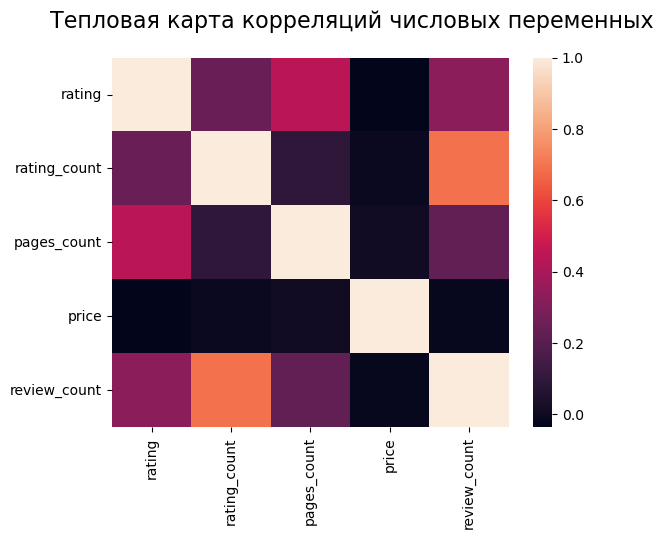

In [119]:
sns.heatmap(df[['rating', 'rating_count', 'pages_count', 'price', 'review_count']].corr())
plt.suptitle('Тепловая карта корреляций числовых переменных', fontsize=16)
plt.show()

По нашему графику можем заметить, что сильнее всего между собой коррелируют количество отзывов и количество оценок, скорее всего, что человек который написал отзыв также ставит оценку. Также сильно коррелирует количество страниц и рэйтинг, можно предположить, что людям больше нравятся объемные книги.

11. Построим диаграмму рассеяния (scatterplot) количества страниц и количества отзывов.

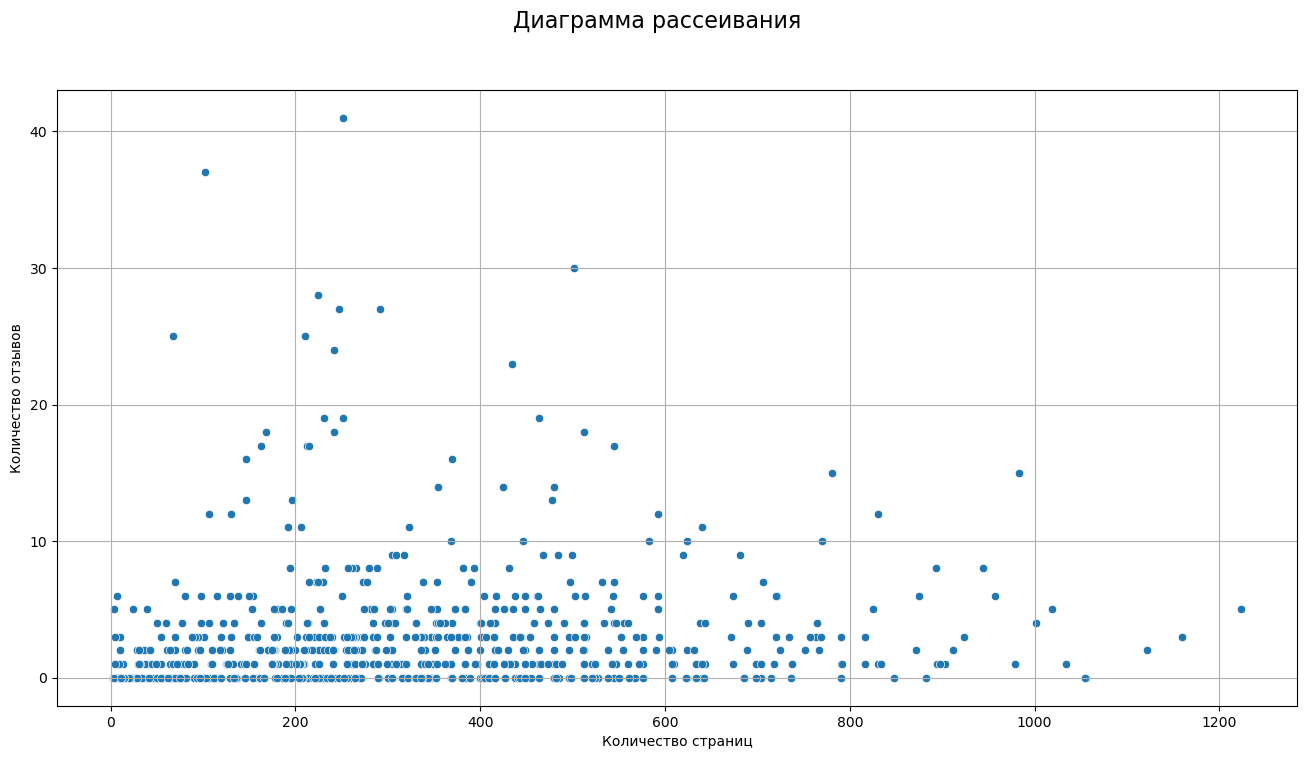

In [123]:
fig, ax = plt.subplots(figsize=(16,8))

sns.scatterplot(data=df, x='pages_count', y='review_count')
plt.suptitle('Диаграмма рассеивания', fontsize=16)
plt.xlabel('Количество страниц')
plt.ylabel('Количество отзывов')
plt.grid()

Какую-то зависимость между этими переменными сложно найти, можно сказать, что очень популярные книги имеют как правило от 100 до 600 страниц. Книги более 600 страниц имеют меньше выбросов по количеству отзывов, возможно это просто потому, что таких книг заметно меньше.

12. Построим линейный график: по оси Х год, по оси Y количество книг.

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


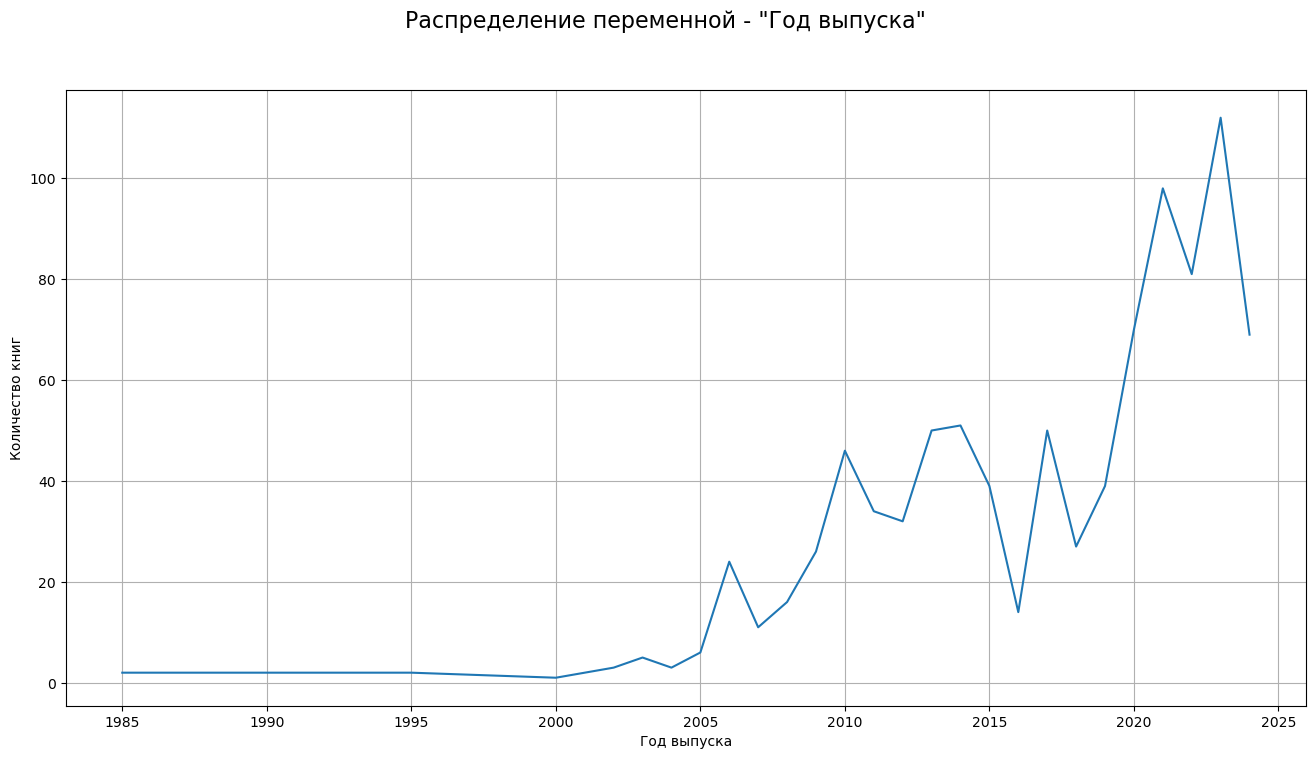

In [131]:
fig, ax = plt.subplots(figsize=(16,8))

data = df[df.year != 0].groupby('year', as_index=False).name.count()


sns.lineplot(data=data, x='year', y='name')
plt.suptitle('Распределение переменной - "Год выпуска"', fontsize=16)
plt.xlabel('Год выпуска')
plt.ylabel('Количество книг')
plt.grid()
plt.show()

Больше всего книг у нас позже 2020 года выпуска, но встречаются и очень старенькие с 1985 года.

12. Построим график распределения.

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


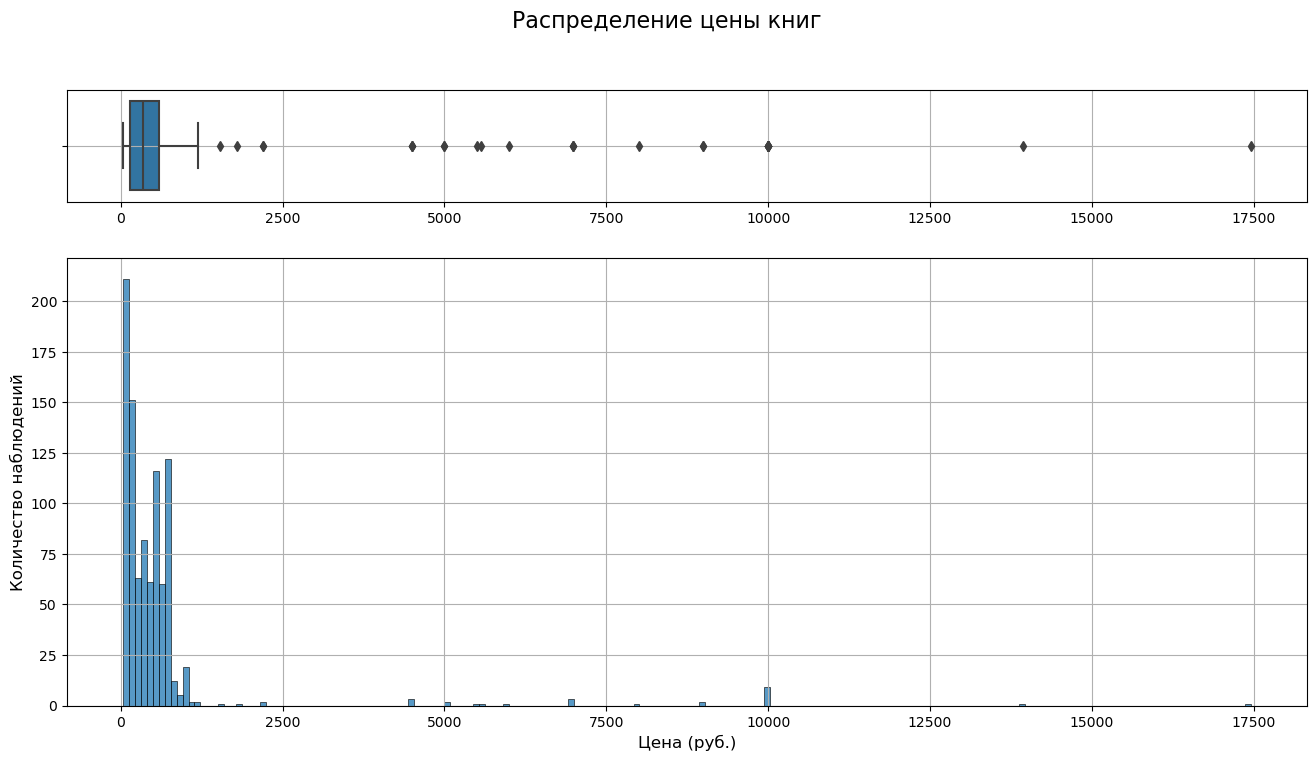

In [144]:
fig, axes = plt.subplots(
    nrows=2, ncols=1, sharex=False, 
    gridspec_kw={"height_ratios": (.2, .8)},
    figsize=(16, 8)
)

sns.boxplot(data=df, x='price', ax=axes[0], orient='h')
sns.histplot(data=df, x='price')
axes[0].set_xlabel('')
axes[1].set_ylabel('Количество наблюдений', fontsize=12)
axes[1].set_xlabel('Цена (руб.)', fontsize=12)

fig.suptitle('Распределение цены книг', 
            fontsize=16
)
axes[0].grid()
plt.grid()
plt.show()

Видно, что цена книг как правило не больше 1000 рублей, но у нас встречаются и очень дорогие книги до 17 500 руб.

Index(['0+', '12+', '16+', '6+', '18+'], dtype='object', name='age')

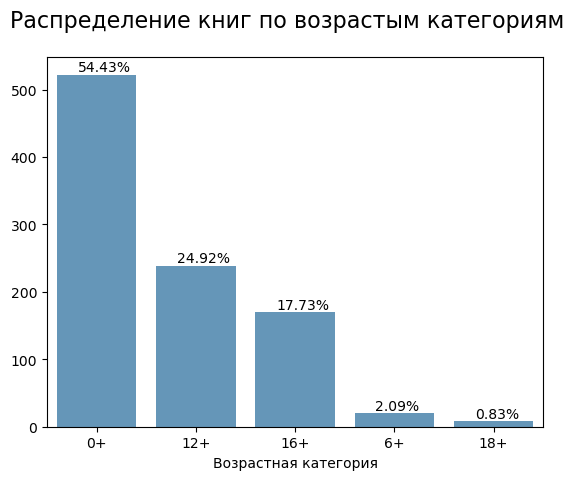

In [172]:
age_cat_sorted = df.age.value_counts()
sns.countplot(data=df, x='age', color='#5799C6', order=age_cat_sorted.index)
for i, value in enumerate(age_cat_sorted):
    plt.text(i-0.19, value + 5, f'{value/age_cat_sorted.sum():.2%}')
plt.suptitle('Распределение книг по возрастым категориям', fontsize=16)
plt.xlabel('Возрастная категория')
plt.ylabel('')
plt.show()

Больше 50% книг не имеют ограничений по возрасту, а также у нас есть книги по программированию для взрослых)))

13. Построим таблицу с авторами книг с именем автора, количество книг в датасете, средней оценкой книг, средним количеством отзывов. Для этого нам нужно обработать дубликаты.

In [178]:
df[df.duplicated(subset=('author', 'name'), keep=False)].sort_values(by='name')

,name,author,link,rating,rating_count,pages_count,price,review_count,text_reviews,year,age,is_popular,char_count
582,40 задач на Python,Джеймс Девис,https://www.litres.ru/audiobook/dzheyms-devis-...,5.0,2,NaN,349.0,0,[],2024,12+,0,0
523,40 задач на Python,Джеймс Девис,https://www.litres.ru/book/dzheyms-devis-33032...,5.0,112,120.0,349.0,3,"[Интересные задачи, разного уровня. Объясняетс...",2024,12+,0,495
512,Fallout. Хроники создания легендарной саги,Эрван Лафлериэль,https://www.litres.ru/audiobook/ervan-laflerie...,4.2,23,NaN,429.0,5,[Книга не про ИСТОРИЮ создания игр серии Fallo...,2017,16+,0,1888
494,Fallout. Хроники создания легендарной саги,Эрван Лафлериэль,https://www.litres.ru/book/ervan-lafleriel/fal...,4.3,18,261.0,609.0,8,"[Отличная книга, для фанатов одноименной игры,...",2017,16+,0,7471
619,IT Компас: как правильно программировать IT-ка...,Илья Кырчумару,https://www.litres.ru/book/ilya-kyrchumaru/it-...,5.0,3,205.0,490.0,1,"[Эта книга не об IT-карьере, а о наборе качест...",2024,0+,0,385
...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,"Тестирование видеоигр, или Легкий способ попас...",Александр Торговкин,https://www.litres.ru/audiobook/aleksandr-torg...,5.0,4,NaN,719.0,0,[],2024,12+,0,0
311,Хочу в геймдев! Основы игровой разработки для ...,Вячеслав Уточкин,https://www.litres.ru/book/vyacheslav-utochkin...,4.3,30,250.0,529.0,6,"[Читаю всё подряд про геймдизайн, теперь думаю...",2022,12+,0,2226
530,Хочу в геймдев! Основы игровой разработки для ...,Вячеслав Уточкин,https://www.litres.ru/audiobook/vyacheslav-uto...,4.7,18,NaN,669.0,2,[Хорошая обзорная книга. Полный экскурс по все...,2022,12+,0,341
59,"Чистый код: создание, анализ и рефакторинг (pd...",Роберт Мартин,https://www.litres.ru/book/robert-s-martin/chi...,4.0,3,464.0,599.0,0,[],0,16+,0,0


У нас 84 наблюдения имеют дубликаты, удалим их предварительно обработав среднюю оценку и количество отзывов.

15. Посторим диаграмму рассеивания цены и количества страниц в разрезе популярных и непопулярных книг

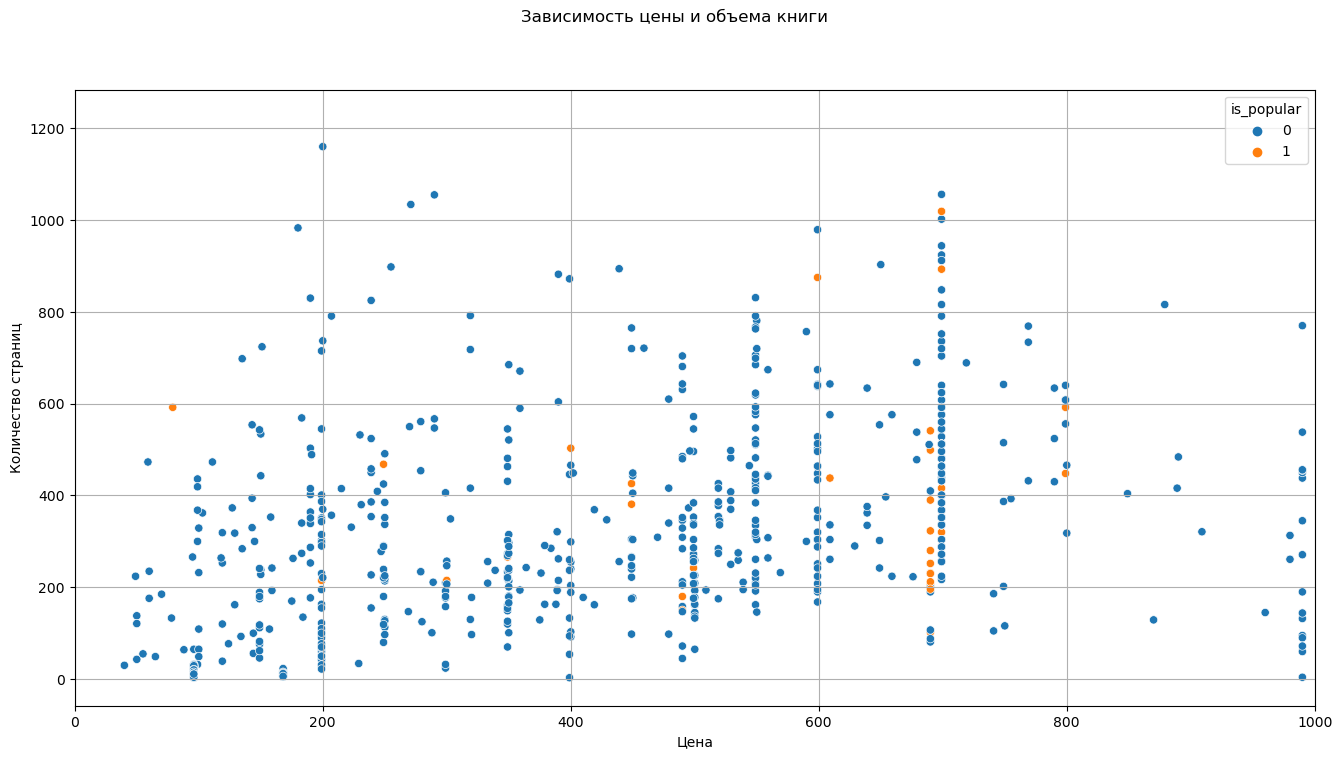

In [243]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.scatterplot(data=df, x='price', y='pages_count', hue='is_popular')
plt.suptitle('Зависимость цены и объема книги')
plt.xlabel('Цена')
plt.ylabel('Количество страниц')
plt.xlim(0, 1000)
plt.grid()

Нельзя сказать, что объемная книга будет стоить дороже, очень много объемных книг стоит недорого. Цена скорее всего зависит от популярности книги чем выше цена, тем больше популярных книг. Хочу заметить что мы установили лимит в 1000 по оси Х.

Возьмем книги за последние 10 лет, и посмотрим как зависит цена от года выпуска книги.

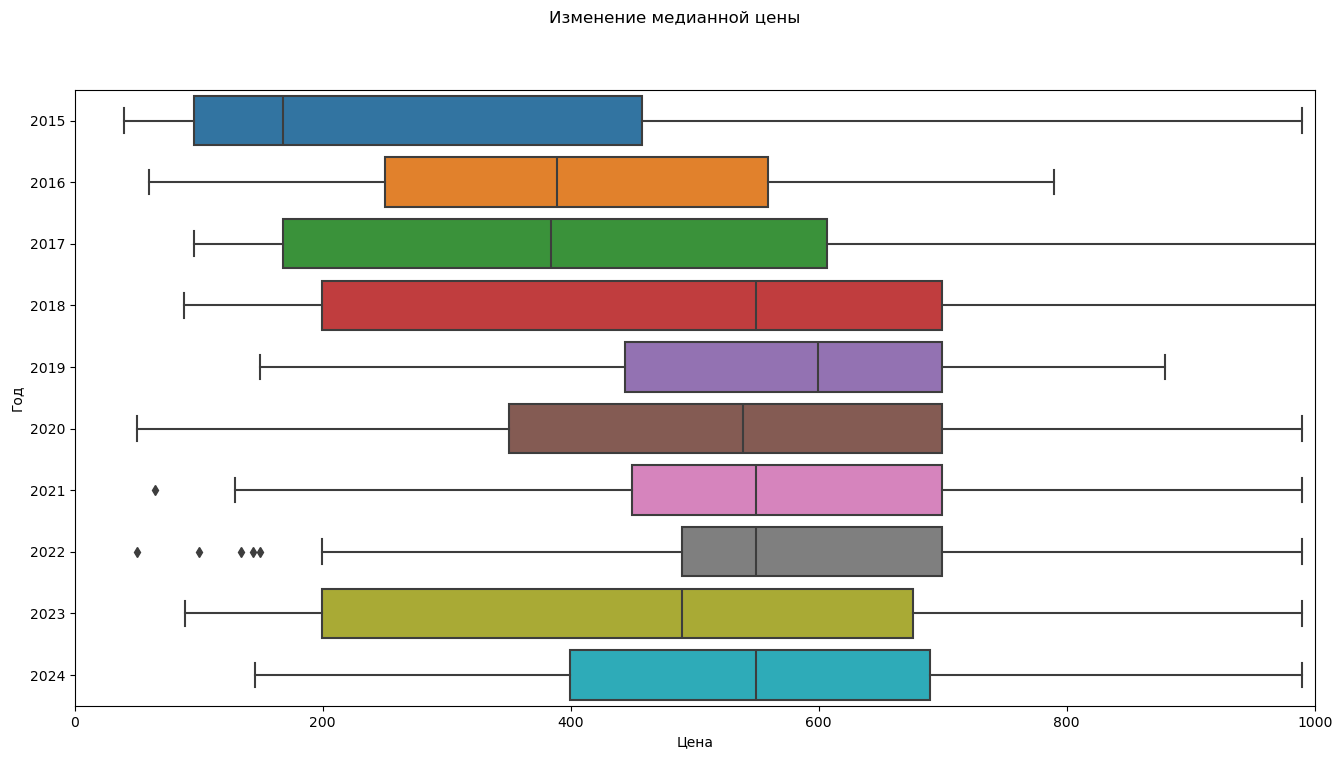

In [245]:
fig, ax = plt.subplots(figsize=(16, 8))

sns.boxplot(data=df[df.year > 2014], x='price', y='year', orient='h')
plt.xlim(0, 1000)
plt.suptitle('Изменение медианной цены')
plt.xlabel('Цена')
plt.ylabel('Год')
plt.xlim(0, 1000)
plt.show()

На книги не старше 2018 года выпуска цена сильно не меняются, а вот начиная с 2017 года медианная цена сильно падает.